In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import minigrid
from IPython.display import display, clear_output
from PIL import Image
import minigrid.wrappers
from src.ppo_lstm import Agent, Args
from src.ppo_lstm.main import make_env
import torch
from tqdm import tqdm

In [2]:
env_id = 'MiniGrid-CustomMaze-S13-v0'

num_envs = 1
args = Args(
    env_id=env_id,
    seq_len=64,
    num_envs = num_envs,
    use_pixels=True,
    one_hot=False,
    hidden_layer_size=256,
    hidden_size=32,
    view_size=3,
    deployment=True,
)

import minigrid.wrappers
from src.environments.minigrid_custom_maze import MiniGridCustomMaze
env = MiniGridCustomMaze(13, 13, agent_view_size = 3, tile_size = 64, render_mode='rgb_array')
env = minigrid.wrappers.RGBImgPartialObsWrapper(env, tile_size=128)

### Idk

In [3]:
import os
import sys
import json
import argparse
from concurrent.futures import ProcessPoolExecutor

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import minigrid
from PIL import Image
import minigrid.wrappers
from src.ppo_lstm import Agent, Args
from src.ppo_lstm.main import make_env
import torch
from tqdm import tqdm
import plotly.graph_objects as go
import os
from datetime import datetime

path = '/workspace/2501/ppo_lstm/important_checkpoints/ppo_lstm_MiniGrid-MemoryS13-v0_3x3_1737817367/checkpoint_4980736.pt'
env_id = 'MiniGrid-MemoryS13Random-v0'
num_envs = 1
args = Args(
    env_id=env_id,
    seq_len=8,
    num_envs=num_envs,
    hidden_layer_size=16,
    hidden_size=8,
    view_size=3,
    deployment=True,
)
run_name = f'test'

base_output_dir = os.path.join('visualisations', 'images', run_name)
img_output_dir = os.path.join(base_output_dir, 'images')
data_output_dir = os.path.join(base_output_dir, 'data')
os.makedirs(img_output_dir, exist_ok=True)
os.makedirs(data_output_dir, exist_ok=True)

env = gym.vector.SyncVectorEnv([make_env(args, seed, run_name) for seed in range(1)])
obs0, _ = env.reset()
agent = Agent(args, envs=env, run_name=run_name)
agent.load(path)
agent.actor_head.rand_move_eps = .1


The obs_dim is:  (184,)


/workspace/2501/ppo_lstm/src/ppo_lstm/agent.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=self.device)


In [8]:
path = '/workspace/2501/ppo_lstm/checkpoints/ppo_lstm_MiniGrid-MemoryS13Random-v0_3x3_1737568046/checkpoint_1835008.pt'
from tqdm import tqdm
from src.ppo_lstm.main import make_env

def view_replay(args, env_id, path):
    run_name = 'test0'
    env = gym.vector.SyncVectorEnv([make_env(args, seed, run_name) for seed in range(1)])
    run_name = 'test_loading'
    obs0, _ = env.reset()
    agent = Agent(args, envs = env, run_name = run_name)
    #LOAD AGENT
    agent.load(path)
    img = Image.fromarray(agent.envs.render()[0])
    agent.actor_head.rand_move_eps = .1
    for step in range(800):
        (obs_tensor, action, log_prob, value, next_observation, reward, 
             next_done, next_hidden, infos) = agent.step_env()
        img = Image.fromarray(agent.envs.render()[0])
        clear_output(wait=True)
        img_display = display(img, display_id=True)
        print(next_hidden)
        agent.observation = next_observation
        agent.hidden = next_hidden
        agent.done = next_done
        import time;
        time.sleep(1. / 60)

def eval_agent(args, env_id, path, num_env, num_steps):
    run_name = 'test0'
    env = gym.vector.AsyncVectorEnv([make_env(args, seed, run_name) for seed in range(num_env)])
    agent = Agent(args, envs=env, run_name=run_name)
    agent.load(path)
    
    # Set evaluation mode
    for module in [agent.feature_extractor, agent.actor_head, agent.critic_head]:
        module.eval()
    
    stats = {
        'total_reward': 0.0,
        'episodes_completed': 0,
        'solved_episodes': 0
    }
    
    for step in tqdm(range(num_steps)):
        _, action, _, _, next_observation, reward, next_done, next_hidden, infos = agent.step_env()
        
        if 'episode' in infos:
            episodes_now = infos['_episode'].sum()
            reward_now = infos['episode']['r'].sum()
            
            # Count solved episodes (r > 0)
            solved_now = sum(r > 0 for r in infos['episode']['r'])
            
            stats['episodes_completed'] += episodes_now
            stats['total_reward'] += reward_now
            stats['solved_episodes'] += solved_now
        
        agent.observation = next_observation
        agent.hidden = next_hidden
        agent.done = next_done
    
    # Final statistics
    avg_reward = stats['total_reward'] / stats['episodes_completed'] if stats['episodes_completed'] > 0 else 0
    solve_rate = stats['solved_episodes'] / stats['episodes_completed'] * 100 if stats['episodes_completed'] > 0 else 0
    
    print(f"\nFinal Results:")
    print(f"Total Episodes: {stats['episodes_completed']}")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Solve Rate: {solve_rate:.1f}%")
    
    return stats

## Small preview

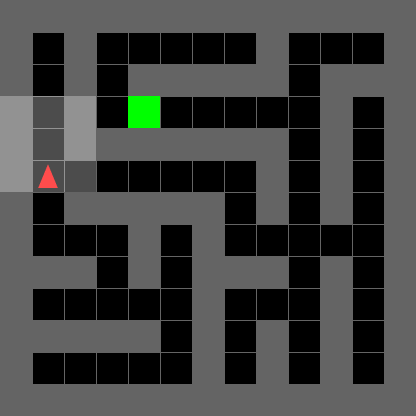

Step: 299


In [9]:
from IPython.display import HTML
import time

import plotly.graph_objects as go

path = '/workspace/2501/ppo_lstm/important_checkpoints/CustomMazeRandomS15_1737796730/checkpoint_31457280.pt'
env_id = 'MiniGrid-CustomMazeS13-v0'

num_envs = 1
args = Args(
    env_id=env_id,
    seq_len=64,
    num_envs = num_envs,
    hidden_layer_size=256,
    hidden_size=32,
    view_size=3,
    deployment=True,
)
run_name = 'test'
env = gym.vector.SyncVectorEnv([make_env(args, seed, run_name) for seed in range(1)])
obs0, _ = env.reset()
agent = Agent(args, envs = env, run_name = run_name)
agent.load(path)
img = Image.fromarray(agent.envs.render()[0])
agent.actor_head.rand_move_eps = .1

for step in range(300):
    (obs_tensor, action, log_prob, value, next_observation, reward, 
            next_done, next_hidden, infos) = agent.step_env()
    
    # Create environment image
    img = Image.fromarray(agent.envs.render()[0])
    print(agent.envs.render()[0].shape)
    
    hidden_data = next_hidden.flatten().detach().cpu().numpy()
    
    # Calculate dimensions for a roughly square shape
    total_units = hidden_data.shape[0]
    width = int(np.sqrt(total_units))
    height = (total_units + width - 1) // width  # Ceiling division
    
    # Reshape the data to be 2D
    reshaped_data = np.pad(hidden_data.flatten(), 
                          (0, width * height - total_units),  # Pad if necessary
                          mode='constant',
                          constant_values=np.nan)
    reshaped_data = reshaped_data.reshape(height, width)
    
    # Create memory heatmap
    fig = go.Figure(data=go.Heatmap(
        z=reshaped_data,
        colorscale='RdBu',
        showscale=True
    ))
    
    fig.update_layout(
        title='Memory Heatmap',
        width=400,
        height=400 
    )
    
    clear_output(wait=True)
    
    # Display both visualizations
    display(img)
    display(fig)
    print(f"Step: {step}")
   
    
    agent.observation = next_observation
    agent.hidden = next_hidden
    agent.done = next_done
    time.sleep(1. / 10)

### Custom 3 x 3 view

(96, 96, 3)


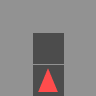

In [12]:
from src.environments.minigrid_custom_maze import MiniGridCustomMaze

env = MiniGridCustomMaze(size=13, agent_view_size=3)
env = minigrid.wrappers.RGBImgPartialObsWrapper(env, tile_size=32)
obs, _ = env.reset()
print(obs['image'].shape)
display(Image.fromarray(obs['image']))


In [1]:
import einops

a = torch.randn(2, 3)
b = torch.randn()